In [1]:
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.clustering import KMeansModel
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pyspark.pandas import read_csv
import pyspark.pandas as ps
ps.set_option('compute.default_index_type', 'distributed')

In [2]:
ALS_model = ALSModel.load("models/als_explicit_collab")
kmeans = KMeansModel.load('models/kmeans')

In [3]:
path = 'data/merged_predictions/stacking_data.csv'

In [4]:
df = ps.read_csv(path)

In [5]:
df = df.fillna(-1) # replace predicted nans with -1

In [6]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

In [7]:
df.head()

,userId,streamId,interactionTime,streamerId,collab_preds,avgInteractionTime,interactionCounts,item_preds,avgInteractionTimeScaled,interactionCountsScaled
0,1,33842865744,2.03125,3047137,1.523179,2.605432,5706,4,1.007278,22.695565
1,1,33846768288,3.06250,3038334,1.135493,2.031250,225,7,0.785295,0.894936
2,1,33886469056,1.00000,3047137,1.523179,2.605432,5706,4,1.007278,22.695565
3,1,33887624992,2.03125,3046060,1.402077,2.402970,3859,2,0.929005,15.349139
4,1,33890145056,3.06250,3050226,1.872689,3.075806,1705,5,1.189128,6.781623


In [8]:
centroids = kmeans.clusterCenters()

In [9]:
centroids

[array([2.74042171, 5.82940959]),
 array([2.6126197e+00, 4.2640000e+04]),
 array([3.54289647e+00, 3.56205556e+03]),
 array([3.28779769e+00, 1.31603333e+04]),
 array([3.44739713e+00, 6.62713514e+03]),
 array([   3.33713562, 1775.05050505]),
 array([2.79294734e+00, 2.73620000e+04]),
 array([  3.18987411, 230.62720403]),
 array([  3.12847051, 759.94425676])]

In [10]:
df['centroids_0'] = df['item_preds'].apply(lambda x: centroids[x][0])
df['centroids_1'] = df['item_preds'].apply(lambda x: centroids[x][1])

In [11]:
df.head()

,userId,streamId,interactionTime,streamerId,collab_preds,avgInteractionTime,interactionCounts,item_preds,avgInteractionTimeScaled,interactionCountsScaled,centroids_0,centroids_1
0,1,33842865744,2.03125,3047137,1.523179,2.605432,5706,4,1.007278,22.695565,3.447397,6627.135135
1,1,33846768288,3.06250,3038334,1.135493,2.031250,225,7,0.785295,0.894936,3.189874,230.627204
2,1,33886469056,1.00000,3047137,1.523179,2.605432,5706,4,1.007278,22.695565,3.447397,6627.135135
3,1,33887624992,2.03125,3046060,1.402077,2.402970,3859,2,0.929005,15.349139,3.542896,3562.055556
4,1,33890145056,3.06250,3050226,1.872689,3.075806,1705,5,1.189128,6.781623,3.337136,1775.050505


In [12]:
spark_df = df.to_spark()
#(training, test) = ratings.randomSplit([0.8,0.2], 38)

In [13]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=[
'collab_preds', 'centroids_0','centroids_1'], outputCol='features')
assembled_data=assemble.transform(spark_df)

In [14]:
assembled_data.columns

['userId',
 'streamId',
 'interactionTime',
 'streamerId',
 'collab_preds',
 'avgInteractionTime',
 'interactionCounts',
 'item_preds',
 'avgInteractionTimeScaled',
 'interactionCountsScaled',
 'centroids_0',
 'centroids_1',
 'features']

In [15]:
(training, test)=assembled_data.randomSplit([0.8,0.2], 38)

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
pbounds = {'regParam': (0,1),
            'elasticNetParam': (0,1)}

In [24]:
def findOptimalModel(regParam=0.3, elasticNetParam=0.8):
    lr = LinearRegression(featuresCol='features',labelCol='interactionTime', regParam=0.3, elasticNetParam=0.8) 
    lrModel = lr.fit(training)
    predictions = lrModel.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol='interactionTime',
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    return -1 *rmse # bayes opt maximizes function

def trainOptimalModel(regParam=0.3, elasticNetParam=0.8):
    lr = LinearRegression(featuresCol='features',labelCol='interactionTime', regParam=0.3, elasticNetParam=0.8) 
    lrModel = lr.fit(training)
    return lrModel
    

In [21]:
optimizer = BayesianOptimization(
    f=findOptimalModel,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1
)

In [22]:
optimizer.probe( # default values for linear regression
    params={'regParam': 0,
            'elasticNetParam': 0},
    lazy=True,
)
optimizer.maximize(
    init_points=5,
    n_iter=20
)

|   iter    |  target   | elasti... | regParam  |
-------------------------------------------------
|  1        | -3.699    |  0.0      |  0.0      |
|  2        | -3.699    |  0.417    |  0.7203   |
|  3        | -3.699    |  0.000114 |  0.3023   |
|  4        | -3.699    |  0.1468   |  0.09234  |
|  5        | -3.699    |  0.1863   |  0.3456   |
|  6        | -3.699    |  0.3968   |  0.5388   |
|  7        | -3.699    |  0.9972   |  0.9939   |
|  8        | -3.699    |  0.83     |  0.6601   |
|  9        | -3.699    |  0.9955   |  0.9914   |
|  10       | -3.699    |  0.997    |  0.004086 |
|  11       | -3.699    |  0.9922   |  0.9997   |
|  12       | -3.699    |  0.8877   |  0.4472   |
|  13       | -3.699    |  0.4323   |  0.352    |
|  14       | -3.699    |  0.6099   |  0.3929   |
|  15       | -3.699    |  0.5532   |  0.702    |
|  16       | -3.699    |  0.1484   |  0.4067   |
|  17       | -3.699    |  0.005837 |  0.9993   |
|  18       | -3.699    |  0.9898   |  0.000304 |


In [23]:
optimizer.max

{'target': -3.6991871662072335,
 'params': {'elasticNetParam': 0.0, 'regParam': 0.0}}

In [39]:
rmses=[]
iterations= []
for i, res in enumerate(optimizer.res):
    iterations.append(i)
    rmses.append(-1 * res['target'])

In [40]:
import matplotlib.pyplot as plt

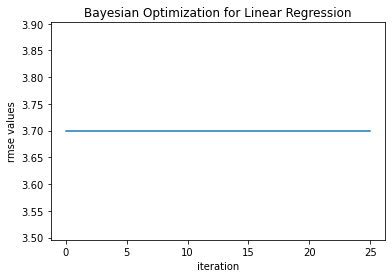

In [43]:
plt.plot(iterations, rmses)
plt.ylabel('rmse values')
plt.xlabel('iteration')
plt.title('Bayesian Optimization for Linear Regression')
plt.show()

In [44]:
lrModel = trainOptimalModel(**optimizer.max['params'])

In [45]:
predictions = lrModel.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol='interactionTime',
                                    predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.6991871662072335


In [46]:
lrModel.write().overwrite().save('models/lin_reg')

In [47]:
model2 = LinearRegressionModel.load('models/lin_reg')# test model

In [48]:
predictions = lrModel.transform(assembled_data)

In [49]:
predictions=predictions.drop('features')

In [50]:
predictions.coalesce(1).write.format('csv').mode("overwrite").option('header', 'true').save('data/final_lr_preds')